# data loading and analysis

load the dataset of 1600000 tweets, 0 means negative whill 4 means positive. Assign columns to the rows and print information about each column for analysis.

In [21]:
import pandas as pd
import numpy as np

columns = ["target", "id", "date", "flag", "user", "text"]
mapping = {0: "negative", 4: "positive"}

data_path = "./data/1_600_000tweets.csv"
df = pd.read_csv(data_path, encoding="ISO-8859-1", low_memory=False, names=columns)
print("dataframes first 5 rows: ")
print(df.head(5))

print()

print("dataframe columns:")
for col in df.columns:
    print(col)

print()

print("dataframe shape:")
print(df.shape)

dataframes first 5 rows: 
   target          id                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  

dataframe columns:
target
id
date
flag
user
text

dataframe shape:
(1600000, 6)


Analyze the dataset, the distribution of positive and negative sentiments should be even. 

distribution of values is 50/50


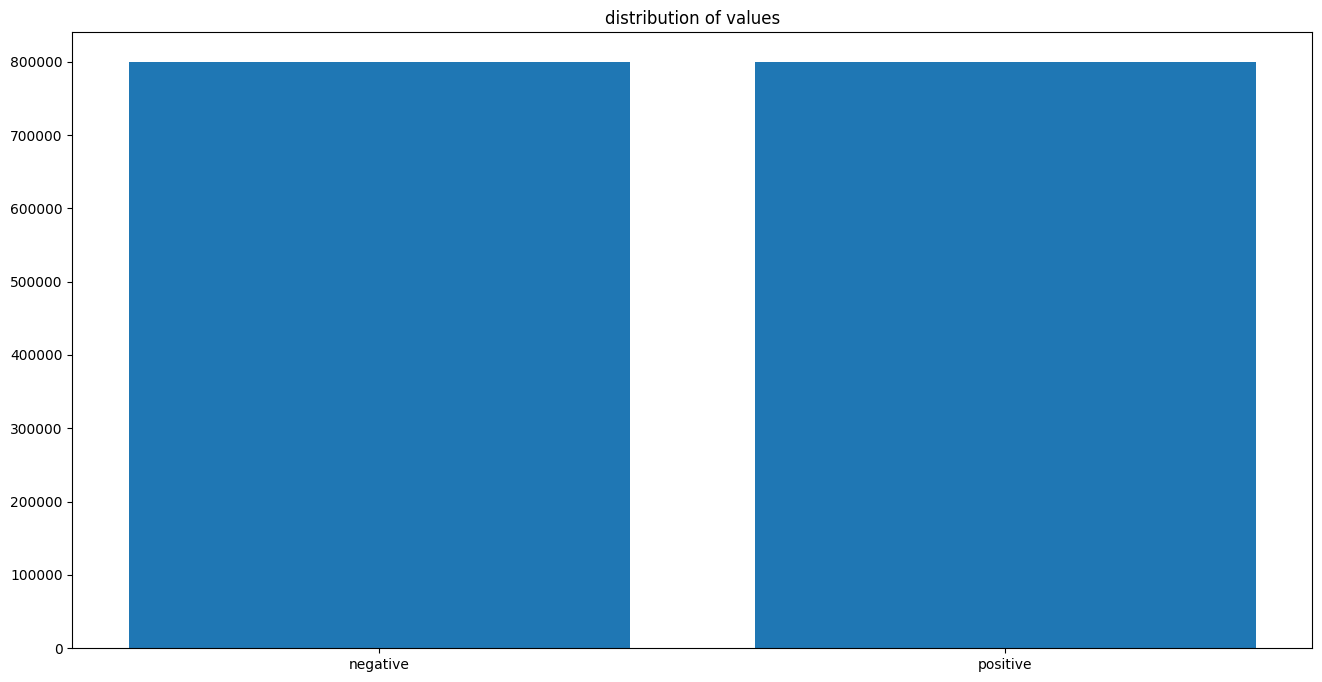

In [22]:
import matplotlib.pyplot as plt
from collections import Counter

targets = Counter(df.target)

# replace target values with their labels
for k, v in mapping.items():
    targets[v] = targets.pop(k)

plt.figure(figsize=(16, 8))
plt.bar(targets.keys(), targets.values())
plt.title("distribution of values")

print("distribution of values is 50/50")
plt.show()

# Data preprocessing

Start my removing links, @ mentions, hashtags, and mass spaces for cleaner more consistent data

In [23]:
import re

def preprocess(text):
    # remove links
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    # remove user mentions
    text = re.sub(r"@\w+", "", text)
    # remove hashtags
    text = re.sub(r"#\w+", "", text)
    # remove special characters
    text = re.sub(r"[^A-Za-z0-9\s]", "", text)
    # remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()
    return text

# apply the preprocessing function to the text column
df["text"] = df["text"].apply(preprocess)

Drop stop words too. stop words are words that add no context to the sentiment, such as the noun or pronoun. a stemmer breaks words into smaller subwords, for example adjustable -> adjust.

In [24]:
import nltk
nltk.download('stopwords')
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

stop_words = stopwords.words('english')
stemmer = SnowballStemmer("english")

def preprocess_text(text):
  tokens = []
  for token in text.split():
    if token not in stop_words:
      tokens.append(stemmer.stem(token))
  return " ".join(tokens)

# apply the preprocessing function to the text column
df["text"] = df["text"].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chand\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Remove uneccessary columns, reduce span from 0-4 with 0 being negative, and 1 being positive

In [ ]:
# drop the unnecessary columns if they exist
if "id" in df.columns and "date" in df.columns and "flag" in df.columns and "user" in df.columns:
    df = df.drop(columns=["id", "date", "flag", "user"])

# Repalce 4 with 1
df["target"] = df["target"].replace(4, 1)
mapping = {0: "negative", 1: "positive"}

print(df.head(5))

   target                                               text
0       0  a that bummer you shoulda got david carr third...
1       0  upset cant updat facebook text might cri resul...
2       0  i dive mani time ball manag save 50 the rest g...
3       0                    whole bodi feel itchi like fire
4       0                            behav im mad i cant see


# Train/Test Split

break the dataset into a testing and training dataset, where training is used to fit the model while testing is used to validate the model

In [26]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.15, random_state=42)

print("train data shape: ", train_data.shape)
print("test data shape: ", test_data.shape)

train data shape:  (1360000, 2)
test data shape:  (240000, 2)


# Tokenization

In [27]:
# Break sentences into their words
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

vocab_size = len(tokenizer.word_index) + 1
print("vocab size: ", vocab_size)

vocab size:  336497


In [28]:
# Make sure sequences arethe same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text), maxlen=50)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text), maxlen=50)

print("x_train shape: ", x_train.shape)
print("x_test shape: ", x_test.shape)

x_train shape:  (1360000, 50)
x_test shape:  (240000, 50)


In [34]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(train_data.target.to_list())

y_train = encoder.transform(train_data.target.to_list())
y_test = encoder.transform(test_data.target.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1360000, 1)
y_test shape: (240000, 1)


Word embedding - words kinda are unusable as text, turn it into a useable vector

In [35]:
import urllib.request
import zipfile
import os

# WARNING: BIG FILE
url = 'http://nlp.stanford.edu/data/glove.6B.zip'
glove_zip_path = 'glove.6B.zip'
glove_dir = 'glove.6B'

# Download
if not os.path.exists(glove_zip_path):
    print("Downloading GloVe embeddings...")
    urllib.request.urlretrieve(url, glove_zip_path)

# Unzip
if not os.path.exists(glove_dir):
    print("Unzipping...")
    with zipfile.ZipFile(glove_zip_path, 'r') as zip_ref:
        zip_ref.extractall(glove_dir)

print("Done.")


Done.


In [36]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Load GloVe
embedding_index = {}
with open('glove.6B/glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Prepare embedding matrix
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = tf.keras.layers.Embedding(
    vocab_size,
    100,
    weights=embedding_matrix,
    input_length=50,
    trainable=False
)

c:\Users\chand\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


# Build the model

In [37]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

sequence_input = Input(shape=(50,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Training on CPU...


In [40]:
history = model.fit(x_train, y_train, batch_size=1024, epochs=15,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/15
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 100s 76ms/step - accuracy: 0.7623 - loss: 0.4861 - val_accuracy: 0.7695 - val_loss: 0.4740 - learning_rate: 0.0010
Epoch 2/15
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 101s 76ms/step - accuracy: 0.7629 - loss: 0.4852 - val_accuracy: 0.7708 - val_loss: 0.4729 - learning_rate: 0.0010
Epoch 3/15
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 100s 75ms/step - accuracy: 0.7637 - loss: 0.4843 - val_accuracy: 0.7691 - val_loss: 0.4759 - learning_rate: 0.0010
Epoch 4/15
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 101s 76ms/step - accuracy: 0.7639 - loss: 0.4829 - val_accuracy: 0.7721 - val_loss: 0.4716 - learning_rate: 0.0010
Epoch 5/15
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 99s 75ms/step - accuracy: 0.7653 - loss: 0.4820 - val_accuracy: 0.7726 - val_loss: 0.4711 - learning_rate: 0.0010
Epoch 6/15
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 99s 74ms/step - accuracy: 0.7640 - loss: 0.4826 - val_accuracy: 0.7721 - val_loss: 0.4718 - learning_rate: 0.0010
Epoch 7/15
1329/1329 ━━━━━━━━━━━━━━━━━━━━ 99s 74ms/step - ac

# Model Evaluation

In [55]:
from sklearn.metrics import classification_report
import numpy as np

# Get predictions
y_pred_probs = model.predict(x_test)
y_pred_1d = (y_pred_probs > 0.5).astype(int)
y_true = y_test.flatten()

# Print classification report
print(classification_report(y_true, y_pred_1d))

7500/7500 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step
              precision    recall  f1-score   support

           0       0.78      0.76      0.77    119825
           1       0.77      0.79      0.78    120175

    accuracy                           0.77    240000
   macro avg       0.77      0.77      0.77    240000
weighted avg       0.77      0.77      0.77    240000



In [57]:
# human evaluation
columns = ["target", "text"]
mean_tweet = [0, "I absolutely despise everything about you, I hate you so much"]
misleading_negative = [0, "I was excited to try this product, but that feeling disappeared almost instantly"]
nice_tweet = [1, "This is absolutely fantastic, I love this so much, great work team!"]
misleading_positive = [1, "Whatever your personal gripe is with perry, never forget he turned Marsh into O'Hoppe, He's rebuilding from within"]

df = pd.DataFrame([mean_tweet, misleading_negative, nice_tweet, misleading_positive], columns=columns)
# Prepare data for prediction
small_test = pad_sequences(tokenizer.texts_to_sequences(df.text), maxlen=50)
y_pred_probs = model.predict(small_test)

# Convert predictions to binary
y_pred_1d = (y_pred_probs > 0.5).astype(int)
# Print predictions
for i in range(len(df)):
    print(f"Tweet: {df.text[i]}")
    print(f"Predicted sentiment: {'positive' if y_pred_1d[i][0] == 1 else 'negative'}")
    print(f"Predicted probability: {y_pred_probs[i][0]}")
    print()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tweet: I absolutely despise everything about you, I hate you so much
Predicted sentiment: negative
Predicted probability: 0.12590545415878296

Tweet: I was excited to try this product, but that feeling disappeared almost instantly
Predicted sentiment: negative
Predicted probability: 0.17235957086086273

Tweet: This is absolutely fantastic, I love this so much, great work team!
Predicted sentiment: positive
Predicted probability: 0.8959451913833618

Tweet: Whatever your personal gripe is with perry, never forget he turned Marsh into O'Hoppe, He's rebuilding from within
Predicted sentiment: positive
Predicted probability: 0.8964073657989502

